In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  8 10:43:48 2021

@author: ellen
"""

# finde path to all pictures ending with "pattern" - *_1.jpg
import re
import os, fnmatch, facemorpher
from pyagender import PyAgender
import cv2
from PIL import Image
import face_recognition
import time
import numpy as np


def find2(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

def average(pictures):
    facemorpher.averager(pictures, plot=True)
    
def morphing(orginele_foto, morph_foto):
    #agender = PyAgender()
    #faces = agender.detect_genders_ages(cv2.imread(orginele_foto))
    #original_age = faces[0]['age']
    pictures = [orginele_foto, morph_foto]
    facemorpher.morpher(pictures, plot=True, out_frames='output')
    # Output is fotos in de folder /output
    
    
def age_estimation(foto):
    agender = PyAgender()
    faces = agender.detect_genders_ages(cv2.imread(foto))
    age = faces[0]['age']
    return round(age)
    
def age_estimation_group(foto_list):
    age_group_detected = []
    age_group_actual = []
    for x in foto_list:
        age = age_estimation(x)
        age_group_detected.append(age)
        age_group_actual.append(x.split("_")[1])
    return age_group_detected, age_group_actual
    
def Face_recognition(known, test):
    known_image = face_recognition.load_image_file(known)
    face_encoding = face_recognition.face_encodings(known_image)[0]
    known_encodings = [face_encoding]
    image_to_test = face_recognition.load_image_file(test)
    image_to_test_encoding = face_recognition.face_encodings(image_to_test)[0]
    face_distances = face_recognition.face_distance(known_encodings, image_to_test_encoding)
    
    for i, face_distance in enumerate(face_distances):
        print("The test image has a distance of {:.2} from known image #{}".format(face_distance, i))
        print("- With a normal cutoff of 0.6, would the test image match the known image? {}".format(face_distance < 0.6))
        print("- With a very strict cutoff of 0.5, would the test image match the known image? {}".format(face_distance < 0.5))
        print()
    return face_distance

def after_morphing(morph, path):
    age_after_morph = []
    face_distance_after_morph = []
    face_distance_before_morph =[]
    actual_age = []
    age_before_morph = []
    result = find2("*_1.png", path)
    save_name = morph.split("/")[-1].replace('.png','.npz')
    for i in result:
        start = time.time()
        morphing(i, morph)
        age_after_morph.append(age_estimation("output/frame009.png"))
        face_distance_after_morph.append(Face_recognition(i.replace("_1.png", ".png"), "output/frame009.png" ))
        face_distance_before_morph.append(Face_recognition(i.replace("_1.png", ".png"), i ))
        actual_age.append(int(i.split("_")[2]))
        age_before_morph.append(age_estimation(i))
        print(age_after_morph)
        print(face_distance_after_morph)
        print(actual_age)
        stop = time.time()
        print(stop-start)
    np.savez(save_name, age_after_morph=age_after_morph,age_before_morph=age_before_morph, actual_age=actual_age, face_dist_after = face_distance_after_morph, face_dist_before=face_distance_before_morph)
   # Plots_print()
    #return age_after_morph, face_distance_after_morph, actual_age, face_distance_before_morph, age_before_morph

def read_npz_after_morph(file):
    x = np.load(file, mmap_mode='r')

    actual_age = x['actual_age'] # Array with actual ages
    age_after_morph = x['age_after_morph'] # Array with detected ages after morphing
    age_before_morph = x['age_before_morph'] # Array with detected ages before morphing
    face_dist_after = x['face_dist_after'] # Face distance after morphing
    face_dist_before = x['face_dist_before'] # Face distance before morphing
    
    return actual_age, age_after_morph, age_before_morph, face_dist_after, face_dist_before

Using TensorFlow backend.


In [36]:
age_actual, age_morph20, age_estimated, face_dist_after20, face_dist_before20 = read_npz_after_morph("average20_30_N3(1).npz")
age_actual, age_morph30, age_estimated, face_dist_after30, face_dist_before30 = read_npz_after_morph("average30_40_N3(0).npz")
age_actual, age_morph40, age_estimated, face_dist_after40, face_dist_before40 = read_npz_after_morph("average40_50_N3(0).npz")
age_actual, age_morph50, age_estimated, face_dist_after50, face_dist_before50 = read_npz_after_morph("average50_60_N3(0).npz")

#age_actual, same for every group
#age_estimated, same for every group, estimated age (no morphing)


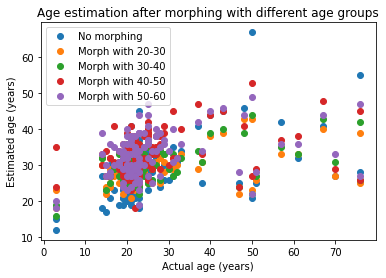

In [37]:
import matplotlib.pyplot as plt

x = list(range(1, len(age_actual)))
plt.figure()
plt.plot(age_actual, age_estimated, 'o', label="No morphing")
plt.plot(age_actual, age_morph20,'o', label="Morph with 20-30")
plt.plot(age_actual, age_morph30, 'o', label="Morph with 30-40")
plt.plot(age_actual, age_morph40, 'o', label="Morph with 40-50")
plt.plot(age_actual, age_morph50, 'o', label="Morph with 50-60")
plt.title('Age estimation after morphing with different age groups')
plt.xlabel('Actual age (years)')
plt.ylabel('Estimated age (years)')
plt.legend()
#plt.savefig('Age_after_morph_all.eps', format='eps')
plt.savefig('Age_after_morph_all.png')
plt.show()

In [38]:
print(np.mean(age_actual))
print(np.mean(age_estimated))
print(np.mean(age_morph20))
print(np.mean(age_morph30))
print(np.mean(age_morph40))
print(np.mean(age_morph50))

26.043478260869566
28.36521739130435
28.82608695652174
29.6
32.96521739130435
33.06956521739131


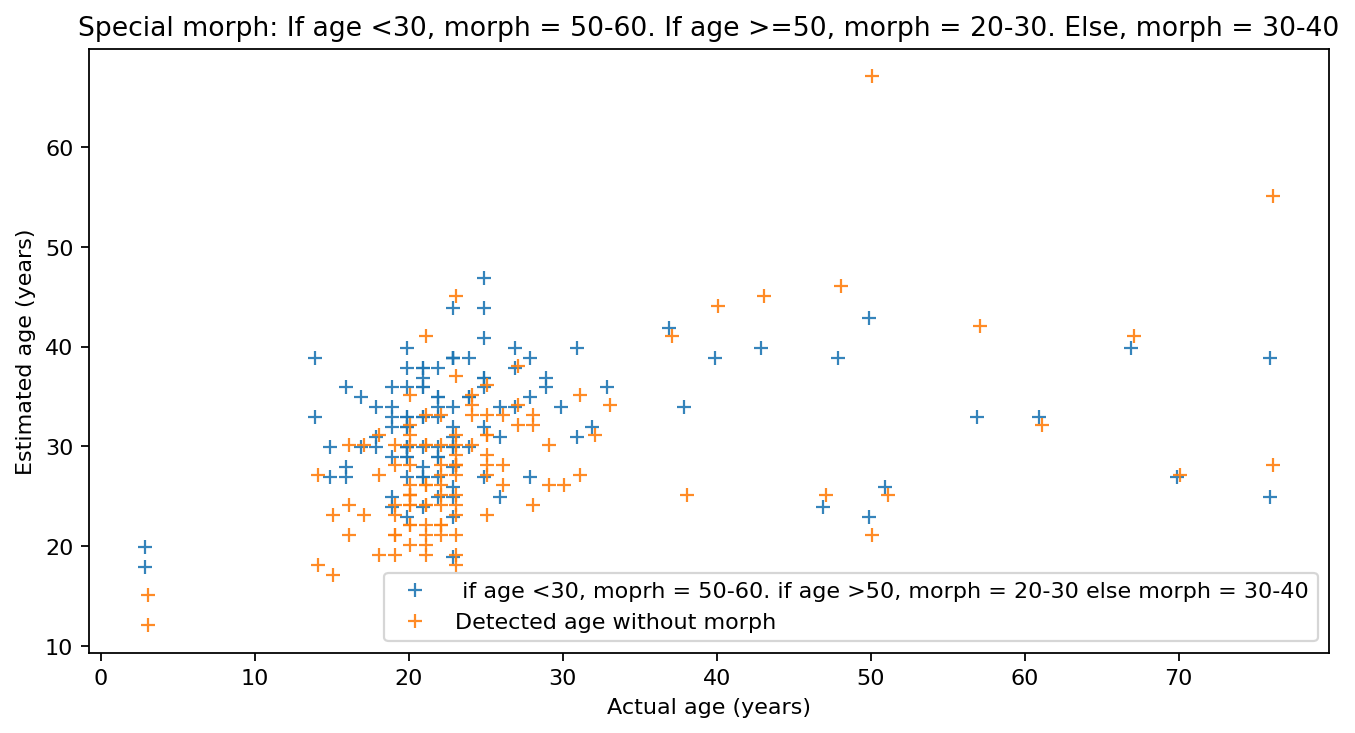

In [57]:
#Special morph!
special_morph = []
for i in range(0,len(age_actual)):
    if age_actual[i] < 40:
        special_morph.append(age_morph50[i])
    elif age_actual[i] >= 50:
        special_morph.append(age_morph20[i])
    else:
        special_morph.append(age_morph30[i])
special_morph = np.array(special_morph)
        
plt.figure(figsize=(10,5), dpi=160)
plt.plot((age_actual-0.1), (special_morph-0.1), '+', alpha=0.9, label=" if age <30, moprh = 50-60. if age >50, morph = 20-30 else morph = 30-40")
plt.plot((age_actual+0.1), (age_estimated+0.1), '+', alpha=0.9, label="Detected age without morph")
plt.title('Special morph: If age <30, morph = 50-60. If age >=50, morph = 20-30. Else, morph = 30-40')
plt.xlabel('Actual age (years)')
plt.ylabel('Estimated age (years)')
plt.legend()
plt.savefig('Age_after_morph_special.png')

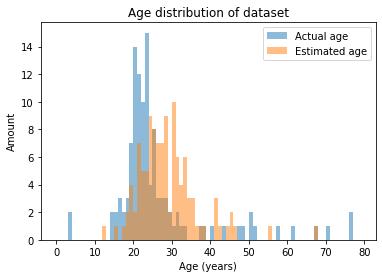

In [51]:
#Age distribution
bins = np.arange(0, 80, 1)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_actual, bins, alpha=0.5, label='Actual age')
plt.hist(age_estimated, bins, alpha=0.5, label='Estimated age')
plt.title('Age distribution of dataset')
plt.xlabel('Age (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_actual_estimated.png')

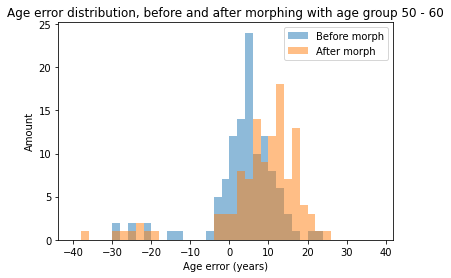

In [63]:
#Age error distributions after morphing per age group
bins = np.arange(-40, 40, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_estimated - age_actual, bins, alpha=0.5, label='Before morph')
plt.hist(age_morph50 - age_actual, bins, alpha=0.5, label='After morph')
plt.title('Age error distribution, before and after morphing with age group 50 - 60')
plt.xlabel('Age error (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group50.png')

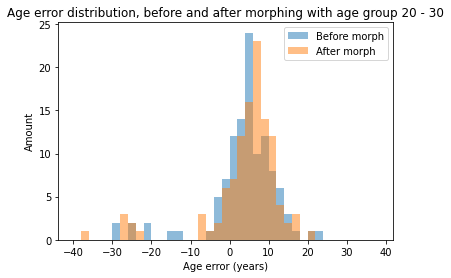

In [64]:
bins = np.arange(-40, 40, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_estimated - age_actual, bins, alpha=0.5, label='Before morph')
plt.hist(age_morph20 - age_actual, bins, alpha=0.5, label='After morph')
plt.title('Age error distribution, before and after morphing with age group 20 - 30')
plt.xlabel('Age error (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group20.png')

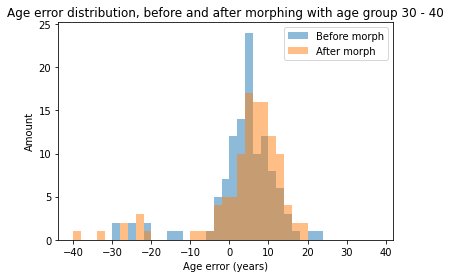

In [65]:
bins = np.arange(-40, 40, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_estimated - age_actual, bins, alpha=0.5, label='Before morph')
plt.hist(age_morph30 - age_actual, bins, alpha=0.5, label='After morph')
plt.title('Age error distribution, before and after morphing with age group 30 - 40')
plt.xlabel('Age error (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group30.png')

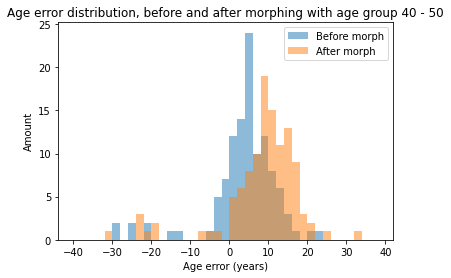

In [66]:
bins = np.arange(-40, 40, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_estimated - age_actual, bins, alpha=0.5, label='Before morph')
plt.hist(age_morph40 - age_actual, bins, alpha=0.5, label='After morph')
plt.title('Age error distribution, before and after morphing with age group 40 - 50')
plt.xlabel('Age error (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group40.png')

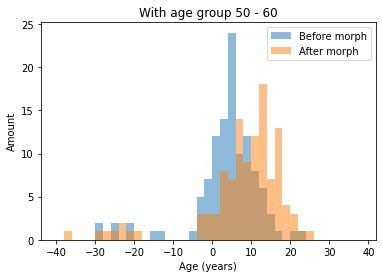

In [67]:
bins = np.arange(-40, 40, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(age_estimated - age_actual, bins, alpha=0.5, label='Before morph')
plt.hist(age_morph50 - age_actual, bins, alpha=0.5, label='After morph')
plt.title('With age group 50 - 60')
plt.xlabel('Age (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group50.png')

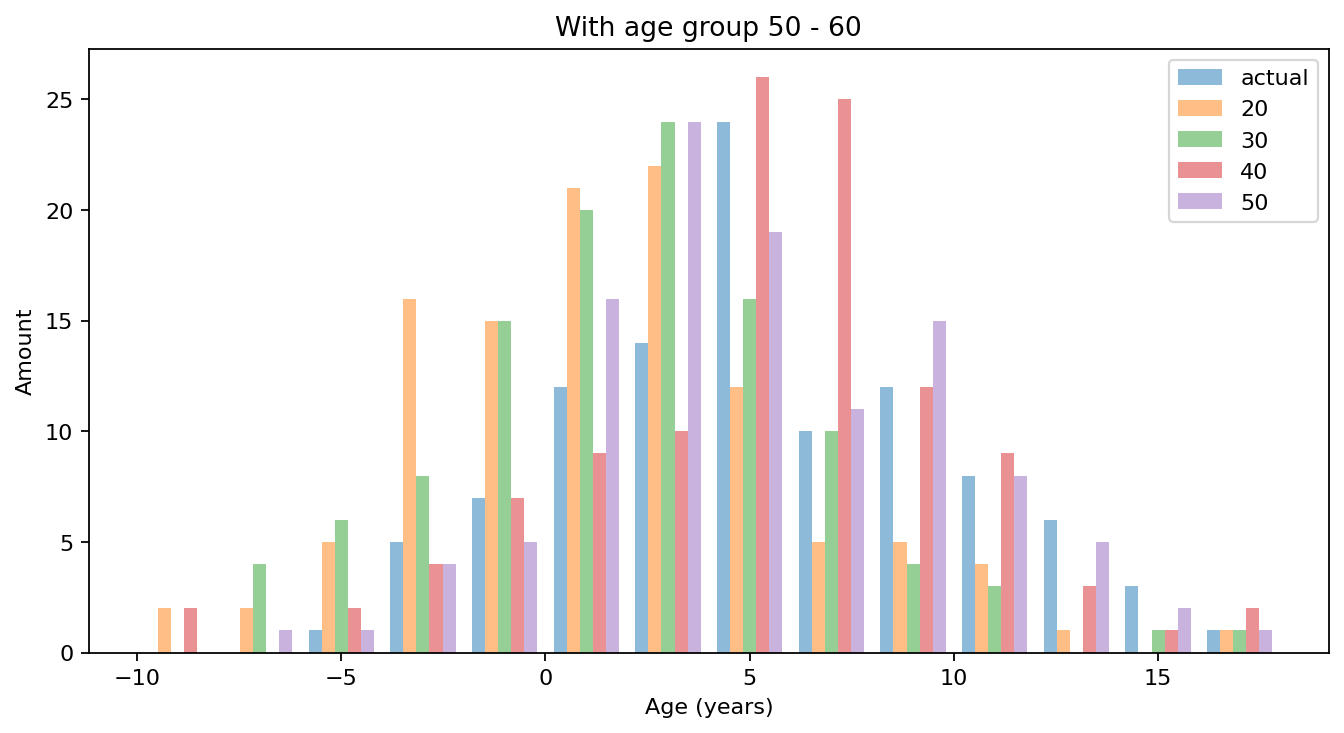

In [80]:
bins = np.arange(-10, 20, 2) #left margin, right margin, step size (years)
plt.figure(figsize=(10,5), dpi=160)
plt.hist([age_estimated - age_actual, age_morph20 - age_actual, age_morph30 - age_actual, age_morph40 - age_actual, age_morph50 - age_actual], 
         bins, alpha=0.5, label=['actual', '20', '30', '40', '50'])
plt.title('With age group 50 - 60')
plt.xlabel('Age (years)')
plt.ylabel('Amount')
plt.legend()
plt.savefig('age_distribution_group50.png')

In [71]:
y

array([-0.90685058,  3.62038343,  1.65831183, ..., -5.95308778,
        1.64652017, -3.89953575])

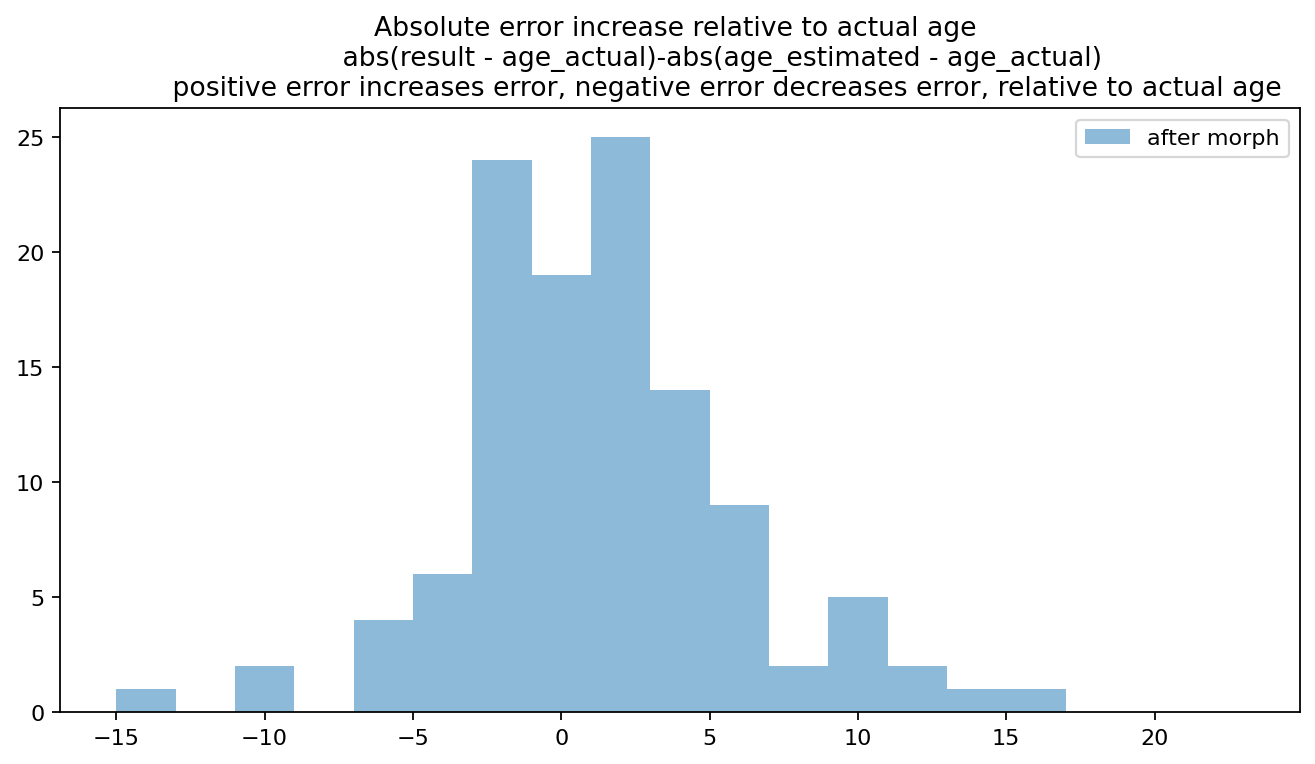

In [81]:
#BONUS
bins = np.arange(-15, 25, 2)
plt.figure(figsize=(10,5), dpi=160)
plt.hist(abs(age_morph20 - age_actual)-abs(age_estimated - age_actual), bins, alpha=0.5, label='after morph')
#plt.plot(age_estimated, age_estimated - age_actual, 'o', label="Detected age without morph")
plt.title('Absolute error increase relative to actual age \n \
          abs(result - age_actual)-abs(age_estimated - age_actual) \n \
          positive error increases error, negative error decreases error, relative to actual age')
plt.legend()
#plt.savefig('Age_after_morph_different_morph_for_age_groups.png')